<h2>Finance - Estimation of covariance matrices using Gaussian Process Latent Variable Model (GP-LVM)</h2>

In statistics, sometimes the covariance matrix of a multivariate random variable is not known but has to be estimated. Estimation of covariance matrices then deals with the question of how to approximate the actual covariance matrix on the basis of a sample from the multivariate distribution. 


The covarianc-matrix tells you something about the assets for a certain amount of time. E.g. if I estiamte the covaraince matrix of those 4 assets taking into account data from the last year (!) then I can expect that this matrix remains valid for the coming 1-3 months - if the markets don't change too much.

If one views that the future will look like the historical period which was used to calculate the volatility you describe, one can use this as an estimate of future risk. There are other methods to estimate future risk such as GARCH.


<p>In this notebook we look at how the GP-LVM performs on the return series of different stocks.</p>
<br>
<b>Way of proceeding:</b>
<ol>
    <li>get returns of $N$ stocks on $D$ different times (e.g. $D$ days)</li>
    <li>put the $N \times D$ matrix into the GP-LVM model to learn the pairwise correlation matrix $K$ between the $N$ stocks</li>
    <li>we feed $K$ into another algorithm to get optimal weights for our portfolio in the other notebook. In this notebook only look at the performance of the GP-LVM (e.g. We evaluate the model by looking at $R^2$-score, ELBO)
    <li>at the end we will visualize the positions of the stocks in the latent space
</ol>

In [1]:
## A different approach to calculate covariance 
import warnings; warnings.simplefilter('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystan
from datetime import datetime, timedelta

%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

from py_code.stan_gplvm import get_stan_code, vb, optimize
from py_code.helper_functions import get_kernel_function, minimal_variance_portfolio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>Read necessary data into pandas dataframe</h2>

We need the data to be in the following format: <br>
    $N$: Number of stocks <br>
    $D$: Number of days <br>
    Dataframe: $D \times N$ <br>
    
For the GP-LVM we are going to work with the transposed $N \times D$ matrix afterwards

In [5]:
data = pd.read_csv('data/example_model_evaluation.csv', index_col=0, parse_dates=['Date'])

#######
print( "number of nan's: {}".format(data.isna().sum().sum()) )
print( "shape data: {}".format(data.shape) )

print( "start_date: {}\nend_date: {}".format(data.index[0], data.index[-1]))
data.head()

number of nan's: 0
shape data: (251, 50)
start_date: 2016-01-05 00:00:00
end_date: 2016-12-30 00:00:00


,CHRW,ZION,T,AMG,CCL,HSY,FOX,WDC,TEL,PXD,...,REGN,FOXA,SRE,CBOE,HBI,MLM,EOG,HP,AMGN,V
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,0.027189,-0.010857,0.006987,-0.008078,-0.009594,-0.003637,-0.000376,-0.004305,-0.002680,0.006594,...,-0.014655,0.000000,0.011912,-0.013908,0.024932,-0.019365,0.006458,-0.011443,-0.001074,0.007530
2016-01-06,-0.004884,-0.029145,-0.001466,-0.043948,-0.002981,0.000685,-0.003759,-0.022281,-0.018808,-0.072062,...,0.020629,0.004889,-0.024287,-0.010143,-0.002333,-0.025154,-0.040069,-0.057506,-0.009168,-0.013111
2016-01-07,-0.001108,-0.030020,-0.016148,-0.060366,-0.021114,-0.023139,-0.021887,-0.016497,-0.052996,0.002325,...,-0.033726,-0.031063,-0.054348,0.006404,0.016700,-0.002080,-0.027629,-0.039025,-0.023864,-0.019663
2016-01-08,0.000475,-0.011254,0.000895,-0.034317,-0.006490,-0.009101,0.000386,-0.042193,-0.010886,-0.004982,...,-0.020480,0.000000,0.009540,-0.004932,-0.047306,-0.026474,0.000916,-0.014636,-0.014838,-0.012332
2016-01-11,-0.021705,-0.019919,0.012224,0.011994,0.036311,-0.007890,0.002700,-0.046759,-0.003955,-0.020114,...,-0.022088,-0.000386,0.021177,0.011191,0.051379,-0.011100,-0.028236,-0.043096,-0.020039,0.014270


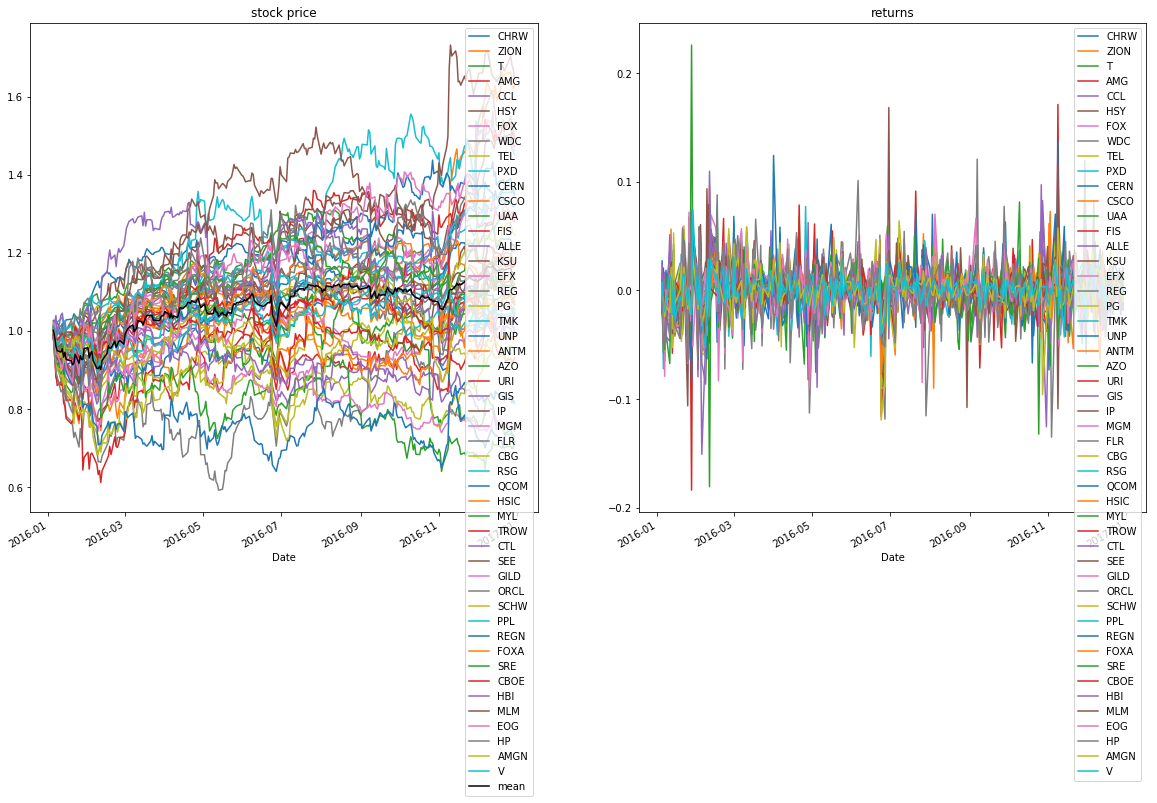

In [6]:
## visualize relative price and returns we are going to work with
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121)
np.cumprod(1+data, axis=0).plot(ax=ax, title='stock price')
np.cumprod(1+data.mean(axis=1)).plot(ax=ax, label='mean', color='black')
ax.legend()

ax = fig.add_subplot(122)
data.plot(ax=ax, title='returns')

plt.show()

<h2>Performance of GP-LVM</h2>

The model is implemented in stan, where the input is:
<ul>
    <li>$N \in \mathbb{R}$: number of stocks (number of datapoints)</li>
    <li>$D \in \mathbb{R}$: number of days (number of features)</li>
    <li>$Q \in \mathbb{R}$: number of latent dimensions</li>
    <li>$Y \in \mathbb{R}^{N \times D}$: return matrix (observations)
</ul>
and the output is:
<ul>
    <li>$X \in \mathbb{R}^{N \times Q}$: latent locations of $N$ datapoints</li>
    <li>$K \in \mathbb{R}^{N \times N}$: covariance matrix between the $N$ datapoints</li>
    <li>$R^2_{stocks} \in \mathbb{R}^{N}$: $R^2$-score of individual stocks</li>
    <li>$R^2 \in \mathbb{R}$: Averaged $R^2$-score</li>
    <li>$ELBO \in \mathbb{R}$: Evidence lower bound</li>
    <li>... some other statistic to evaluate the model</li>
</ul>

<br>
We use Variational Bayes (vb). <br>
The complete stan code is in 'py_code/stan_gplvm.py'.

In [7]:
# specify kernels we want to compare. Only 'linear', 'squared_exp', 'exp', 'matern32', 'matern52' allowed
# can be any 3-tupel from the list above.
kernels = {
    'linear': ['linear'],
    'squared_exp': ['squared_exp'],
    'exp': ['exp'],
    #'matern32': ['matern32'],
    #'matern52': ['matern52'],
    'lin + exp': ['linear', 'exp'],
    #'lin + exp + sq': ['linear', 'exp', 'squared_exp']
}

models = {}
for key, value in kernels.items():
    stan_code = get_stan_code(value)
    print('compiling {} model.'.format(key))
    models[key] = pystan.StanModel(model_code=stan_code)
    
N_models = len(models)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4a1afc13258bba195b7437c8325d3120 NOW.


compiling linear model.
compiling squared_exp model.


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8de0faaf13c5251f31d2fcf59849d59b NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb8f3b6ba89dec450565e61c46ada342 NOW.


compiling exp model.


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c4d13a843482eb9fc6a06c744cc76d52 NOW.


compiling lin + exp model.


<h3>Model Performance</h3>
Before we start building our portfolio, lets look at some statistics of the model.
In the following we will look at those statistics:
<ul>
    <li>R2-score: measuring the reconstruction error</li>
    <li>log-likelihood for the optimization case</li>
    <li>Evidence lower bound (ELBO), which is a lower bound to the Evidence (log-marginal-likelihood) in the variational approximation</li>
</ul>
We will analyse those measures for different latent dimensions $Q$ and different kernels.

In [8]:
D, N = data.shape
stock_list = data.columns

Y = data.T.values        #data is in format DxN, Y for GPLVM needs to be NxD
Q_list = [1,2,3,4,5]     #list of latent dimensions
## Analysis dones for different latent dimensions

In [11]:
data.T.head()

Date,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,2016-01-19 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
CHRW,0.027189,-0.004884,-0.001108,0.000475,-0.021705,0.019919,-0.004605,0.007019,0.006811,0.001573,...,-0.016148,0.020654,-0.001206,0.001342,-0.002144,0.000940,-0.000805,-0.013561,0.003539,-0.006375
ZION,-0.010857,-0.029145,-0.030020,-0.011254,-0.019919,-0.004148,-0.046647,0.004369,-0.028273,-0.017905,...,-0.023467,0.015941,0.028337,-0.006149,0.002292,0.002744,0.001596,-0.014796,-0.011322,0.005843
T,0.006987,-0.001466,-0.016148,0.000895,0.012224,-0.001473,-0.004720,0.016597,-0.009038,0.015298,...,0.004096,0.010799,0.008310,-0.002590,0.008499,0.000234,-0.001872,-0.003048,0.003293,-0.003047
AMG,-0.008078,-0.043948,-0.060366,-0.034317,0.011994,0.003902,-0.038205,0.005032,-0.027462,0.003198,...,-0.019156,-0.015085,0.004992,0.002177,-0.009640,-0.013025,0.007432,-0.009514,0.001810,0.009519
CCL,-0.009594,-0.002981,-0.021114,-0.006490,0.036311,0.013719,-0.042063,-0.008400,-0.040624,-0.015252,...,-0.027568,-0.003495,0.022798,0.011431,-0.012808,0.011830,-0.007354,-0.008549,-0.003832,0.001346


Variational Bayesian methods are a family of techniques for approximating intractable integrals arising in Bayesian inference and machine learning.  It makes sense to use baysian infrastructure, as we want to fit the parameters correctly. 

The Gaussian process latent variable model (GPLVM) is a novel unsupervised approach to nonlinear low dimensional embedding. A series of experiments have been carried out comparing and combining the GPLVM to the conventional and widely used linear dimension reduction technique of principal component analysis (PCA).

Latent variables are useful because data has structure, observed high dimesional data often lies on lower-dimensional manifolds. Lower dimensional representations are easier to work with and allows for interpolation between oserved datapoint. In a process of dimensionality reduction we assume that observed variables result from a smaller set of latent variables. 


In [8]:
%%time

r2_stocks = np.zeros((N_models, len(Q_list), N))   #R2 for each datapoint (stock)
r2_N = np.zeros((N_models, len(Q_list)))           #R2 score averaged over N (stocks)
elbo = np.zeros((N_models, len(Q_list)))           #variational bayes evidence lower bound
#ll = np.zeros((N_models, len(Q_list)))             #optimization log likelihood



tries = 3                    #algo does not converge every time. 
                             #Try many times and take best result based on ELBO
for i, (key, model) in enumerate(models.items()):
    for j, Q in enumerate(Q_list):
        print('calculations for {} model. Q = {}'.format(key, Q), flush=True)

        #opt = optimize(Y, model, Q, tries=tries)
        #r2_N[i,j] = opt['R2_hat_N']
        #r2_stocks[i,j,:] = opt['R2_hat_vec_N']
        #ll[i,j] = opt['log_likelihood']
        
        n_error, should_break, n_error_max = 0, False, 5
        while n_error<n_error_max:    # sometimes, bad initialization leads to RuntimeError, 
                                      # if more then 5 times: break.
            try:
                diagnostic, sample = vb(Y, model, Q, tries=tries) #  Variational Bayes
                n_error = n_error_max
            except RuntimeError:
                n_error += 1
                if n_error == n_error_max: should_break = True
                print('RuntimeError')
                
        if should_break:
            break
            
        r2_N[i,j] = sample.filter(regex='^R2_hat_N$').mean(axis=0).values
        r2_stocks[i,j,:] = sample.filter(regex='^R2_hat_vec_N.\d{1,3}$') \
                                    .mean(axis=0).values
        elbo[i,j] = diagnostic.loc[:, 'ELBO'].values[-1]
        
    if should_break:
        print('RuntimeError occurred too often.')
        break

calculations for squared_exp model. Q = 1
calculations for squared_exp model. Q = 2
calculations for squared_exp model. Q = 3
calculations for squared_exp model. Q = 4
calculations for squared_exp model. Q = 5
calculations for exp model. Q = 1
calculations for exp model. Q = 2
calculations for exp model. Q = 3
calculations for exp model. Q = 4
calculations for exp model. Q = 5
calculations for linear model. Q = 1
calculations for linear model. Q = 2
calculations for linear model. Q = 3
calculations for linear model. Q = 4
calculations for linear model. Q = 5
calculations for lin + exp model. Q = 1
calculations for lin + exp model. Q = 2
calculations for lin + exp model. Q = 3
calculations for lin + exp model. Q = 4
calculations for lin + exp model. Q = 5
CPU times: user 29min 12s, sys: 7.23 s, total: 29min 20s
Wall time: 29min 50s


Figures are more stable if N is large.


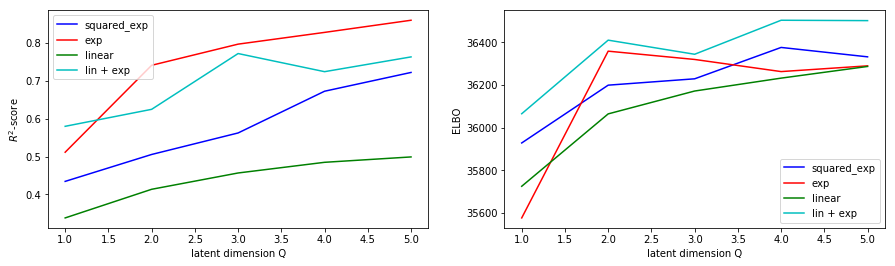

In [9]:
## plot r2-score
c = ['b', 'r', 'g', 'c', 'grey', 'm', 'y', 'w', 'y']

    
fig = plt.figure(figsize=(15,4))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)


for i, model_name in enumerate(models.keys()):
    ax1.plot(Q_list, r2_N[i,:], c[i], label=model_name)
    ax1.set_xlabel('latent dimension Q')
    ax1.set_ylabel('$R^2$-score')
    ax1.legend()
    
    ax2.plot(Q_list, elbo[i,:], c[i], label=model_name)
    ax2.set_xlabel('latent dimension Q')
    ax2.set_ylabel('ELBO')
    ax2.legend()

    
print('Figures are more stable if N is large.')

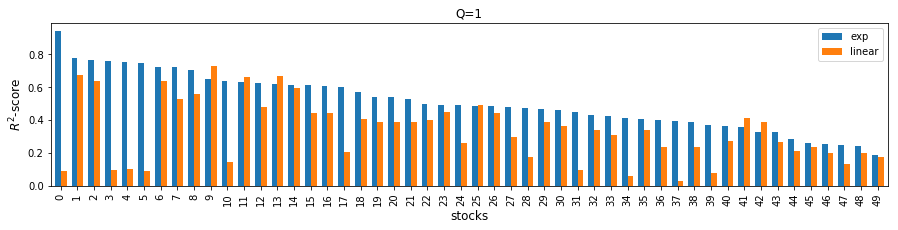

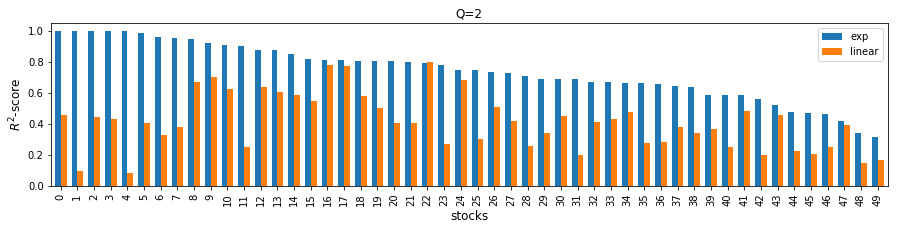

In [10]:
## plot individual R2 for linear and exp kernel
Q_show = [1,2]
kernel_show = ['exp', 'linear']   # items must be in models.keys() 
                                  # plot is sorted with respect to first kernel

index_show = list( map( lambda x: list( models.keys() ).index(x), kernel_show) )


for j, Q in enumerate(Q_show):
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(111)
    
    tmp = pd.DataFrame( r2_stocks[index_show, j, :].T, columns=kernel_show )
    tmp.sort_values(by=kernel_show[0], ascending=False, inplace=True)
    tmp.reset_index(drop=True).plot(kind='bar', width=.7, figsize=(15,3), ax=ax)
    
    ax.set_xlabel('stocks', fontsize=12)
    ax.set_ylabel('$R^2$-score', fontsize=12)
    ax.set_title('Q={}'.format(Q), fontsize=12)

<h3>Postion in latent-space for Q=2</h3>
<p>For a stationary kernel the correlation between the stocks is distance dependent.
    For example: for squared exponential or the exponential kernel the correlation is stronger the closer the stocks are to eachother.</p>

In [11]:
model_name = 'exp'
model = models[model_name]
Q = 2

X = np.zeros((N, Q))  # postion in latent space

tries = 10

# if runtime error occurres, just run the block again
diagnostic, sample = vb(Y, model, Q, tries=tries)
X = sample.filter(regex='^X.\d{1,4}.\d{1,3}$') \
                .mean(axis=0).values.reshape(Q, N).T

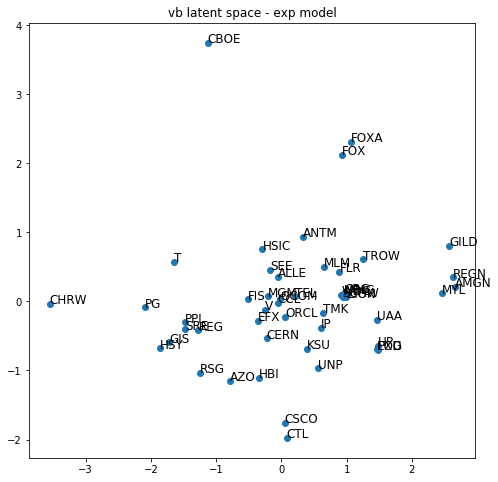

In [12]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

s = ax.scatter(*X.T)
for j,stock in enumerate(stock_list):
    ax.annotate(stock, X[j], fontsize=12)
ax.set_title('vb latent space - {} model'.format(model_name));